In [1]:
import tarfile
import time
import matplotlib.pyplot as plt
from input_output.index_io import save_lexicon
from data_preprocessing.data_preprocessing import preprocess_tokenize

In [2]:
def parse_documents_from_tsv(tar_path):
    documents = {}
    with tarfile.open(tar_path, "r:gz") as tar:
        tsv_file = tar.extractfile('collection.tsv')
        if tsv_file:
            content = tsv_file.read().decode('utf-8')
            lines = content.split('\n')
            for line in lines:
                if '\t' in line:
                    doc_id, doc_content = line.split('\t', 1)
                    documents[doc_id] = doc_content
    return documents

In [3]:
def variable_byte_encode(number):
    """Encodes a number using variable byte encoding."""
    if number == 0:
        return [0]

    bytes_list = []
    while number > 0:
        bytes_list.insert(0, number % 128)
        number >>= 7

    # Set the most significant bit to 1 for all but the last byte
    for i in range(len(bytes_list) - 1):
        bytes_list[i] |= 0x80
    bytes_list[-1] |= 0x00  # Ensure the last byte is in the range 0-127

    return bytes_list

In [4]:
def sort_and_merge_postings(postings_lists):
    for term_id, postings in postings_lists.items():
        # Ensure doc_ids are integers
        cleaned_postings = {int(doc_id): freq for doc_id, freq in postings.items()}

        last_doc_id = 0
        encoded_postings = []
        for doc_id, freq in cleaned_postings.items():
            gap = doc_id - last_doc_id
            encoded_gap = variable_byte_encode(gap)
            encoded_freq = variable_byte_encode(freq)
            encoded_postings.extend(encoded_gap)
            encoded_postings.extend(encoded_freq)
            last_doc_id = doc_id

        postings_lists[term_id] = encoded_postings
    return postings_lists


In [5]:
def create_postings_lists(documents, lexicon):
    """
    Updated to use term IDs from the lexicon.
    """
    postings_lists = {}
    for doc_id, document in documents.items():
        for word in document:
            term_id = lexicon.get(word)
            if term_id is not None:
                if term_id not in postings_lists:
                    postings_lists[term_id] = {}
                postings_lists[term_id].setdefault(doc_id, 0)
                postings_lists[term_id][doc_id] += 1
    return postings_lists

In [6]:
def create_lexicon(parsed_documents):
    """
    Create a lexicon mapping terms to unique IDs.

    Args:
    parsed_documents (dict): Parsed documents with document IDs as keys and contents as values.

    Returns:
    dict: A dictionary mapping terms to unique IDs.
    """
    lexicon = {}
    current_id = 0
    for content in parsed_documents.values():
        for word in content:
            if word not in lexicon:
                lexicon[word] = current_id
                current_id += 1
    return lexicon

In [7]:
def save_inverted_index(inverted_index, filename):
    with open(filename, 'wb') as file:
        for term_id, encoded_postings in inverted_index.items():
            # Apply variable byte encoding to the term ID
            file.write(bytes(variable_byte_encode(term_id)))

            # Write the length of the encoded postings list (variable byte encoded)
            postings_length_encoded = variable_byte_encode(len(encoded_postings))
            file.write(bytes(postings_length_encoded))

            # Write the encoded postings list
            file.write(bytes(encoded_postings))

In [8]:
def measure_performance(full_documents, sizes,compiled_re,stemmer,stop_words,punctuation_translator):
    times = []
    last_size = 0
    original_postings_lists = {}  # Original postings lists as dictionaries
    lexicon = {}

    elapsed_time = 0

    for size in sizes:
        # Select only the new subset of documents
        new_docs = {doc_id: full_documents[doc_id] for doc_id in list(full_documents)[last_size:size]}
        start_time = time.time()

        for doc_id, content in new_docs.items():
            new_docs[doc_id] = preprocess_tokenize(content,compiled_re,stemmer,stop_words,punctuation_translator)

        # Update lexicon and original postings lists with new documents
        new_lexicon = create_lexicon(new_docs)
        lexicon.update(new_lexicon)
        new_postings_lists = create_postings_lists(new_docs, lexicon)
        for term_id, new_postings in new_postings_lists.items():
            if term_id not in original_postings_lists:
                original_postings_lists[term_id] = new_postings
            else:
                for doc_id, freq in new_postings.items():
                    if doc_id in original_postings_lists[term_id]:
                        original_postings_lists[term_id][doc_id] += freq
                    else:
                        original_postings_lists[term_id][doc_id] = freq
        print(original_postings_lists)
        # Apply variable byte encoding to the postings lists
        encoded_postings_lists = sort_and_merge_postings({term_id: postings for term_id, postings in original_postings_lists.items()})
        
        save_inverted_index(encoded_postings_lists, "../data/inverted_index_" + str(size) + ".bin")

        elapsed_time = elapsed_time + time.time() - start_time
        times.append(elapsed_time)
        print(f"Inverted index generation for {size} documents took {elapsed_time:.2f} seconds.")

        last_size = size  # Update last_size for the next iteration

    return times

In [9]:
tar_path = '../data/msmarco/collection.tar.gz'
full_documents = parse_documents_from_tsv(tar_path)

In [10]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
compiled_re = re.compile(r'[^a-z0-9\\s]')
punctuation_translator = str.maketrans('', '', string.punctuation)

In [11]:
collection_sizes = [1000]
times = measure_performance(full_documents, collection_sizes,compiled_re,stemmer,stop_words,punctuation_translator)
#Fix term_id decoding

{0: {'0': 1, '176': 1, '655': 1, '667': 1, '741': 1, '799': 1, '800': 1, '980': 1}, 1: {'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1}, 2: {'0': 1, '3': 1, '7': 1, '256': 1, '859': 1, '860': 1, '861': 1, '863': 1, '865': 1, '867': 1, '868': 1}, 3: {'0': 1, '955': 1}, 4: {'0': 1, '238': 1}, 5: {'0': 1, '116': 1, '132': 1, '853': 1, '934': 1}, 6: {'0': 1, '348': 1}, 7: {'0': 1, '536': 1, '538': 1}, 8: {'0': 1, '61': 1, '203': 1, '235': 1, '323': 1, '752': 1}, 9: {'0': 1, '41': 1, '183': 1, '184': 1, '604': 1, '699': 1, '700': 1, '701': 1, '702': 1, '703': 1, '705': 1, '706': 1, '707': 1, '708': 1, '874': 1, '949': 1}, 10: {'0': 1}, 11: {'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1, '89': 1, '110': 1, '113': 2, '115': 1, '122': 1, '123': 1, '124': 1, '128': 1, '300': 1, '303': 1, '304': 1, '308': 1, '377': 1, '402': 1, '629': 1, '631': 1, '833': 2, '866': 1, '875': 1, '891': 2, '895': 1, '896': 1, '977': 1}, 12: {'0': 1}, 

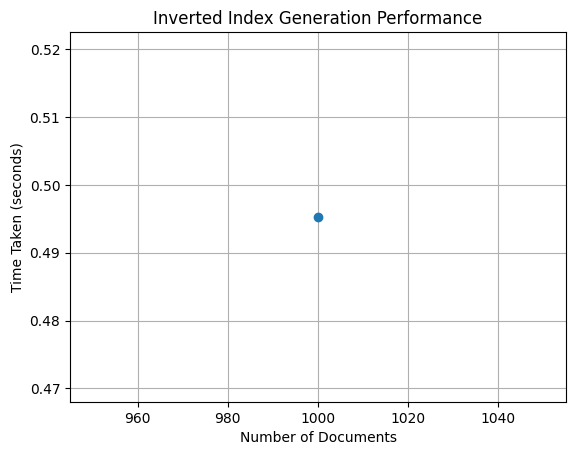

In [12]:
plt.plot(collection_sizes, times, marker='o')
plt.xlabel('Number of Documents')
plt.ylabel('Time Taken (seconds)')
plt.title('Inverted Index Generation Performance')
plt.grid(True)
plt.show()

In [13]:
from input_output.index_io import save_lexicon

#save_lexicon(create_lexicon(full_documents),"../data/lexicon.txt")